In [141]:
import random
import numpy as np
import matplotlib
import sys
import numba
from tqdm.notebook import tqdm
import time
import multiprocessing as mp
from numba import jit, prange
from numba import config, njit, threading_layer
from matplotlib import pyplot as plt
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

### NOTEBOOK 2
### Indhold: 
Udvidet Prisoner's dilemma Tilføjet Nuke mulighed \
Almindelig Q-learner, master Q-learner \
Tilføjet master-theta eller epsilon, ændring over generationer

In [142]:

@njit
def master_q_player(prices, Q, epsilon, p2,t):
    if random.uniform(0,1) < epsilon:
        p3 = int(np.random.choice(len(prices)))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = int(np.argmax(Q[:,p2]))
    return p3

In [143]:
@njit
def npc_player_gen2(options, q_table, epsilon, prev, time):
    if prev[time-2] ==0 and prev[time-1]==0 and prev[time]==0:
        npc_choice = 1
    elif prev[time] == 1:
        npc_choice = 0
    else:
        npc_choice = prev[time]

    return npc_choice

In [144]:
@njit
def Coop_lover():
    return 0

In [145]:
@njit
def npc_master_opponent(options, q_table, my_choice, their_choice, q_counter, npc_counter, nukecounter):
    if nukecounter <= 400: 
        if my_choice[npc_counter-1] == 1 and their_choice[q_counter-1] == 2: 
            nukecounter = nukecounter + 1
            #print("adding a nuke counter", nukecounter)
            if random.uniform(0,1) < (1 - (nukecounter / 400)):
                npc_choice = 1
            else:
                npc_choice = 0
        else:
            npc_choice = int(np.random.choice(len(options)))
            
    else: 
        npc_choice = 0
    
    return int(npc_choice), int(nukecounter)

In [146]:
random.seed(1235)
@njit
def PD_rewards(p1,p2):
    x = np.array(
            [[(12,12), (0,13), (-12,-12)],
            [(13,0), (1,1), (-12,-12)],
             [(-12,-12), (-12,-12), (-12,-12)]]
             )
    val_p1, val_p2 = x[p1,p2]
    
    return val_p1, val_p2
        

In [147]:
def moving_avg(fst_arr, snd_arr, window_size):

    moving_averages = []
    moving_averages2 = []
    i = 0
    while i < len(fst_arr) - window_size + 1:
    
        # Calculate the average of current window
        window_average = np.sum(fst_arr[
        i:i+window_size]) / window_size
        window_average2 = np.sum(snd_arr[
        i:i+window_size]) / window_size
        
        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)
        moving_averages2.append(window_average2)

        
        # Shift window to right by one position
        i += 1
    return moving_averages, moving_averages2

def prof_means(prof_arr1, prof_arr2):
    return np.mean(prof_arr1, axis=0), np.mean(prof_arr2, axis=0)

In [148]:
@njit
def regular_update(Q, prev, alpha, delta, prices, indic):
     if indic == 1: 
         p1 = prev[0,0]
         p2 = prev[1,0]
         p22 = prev[1,1]
         pe1 = Q[prev[0,0],prev[1,0]]
         ne1 = PD_rewards(p1,p2)[0] + delta* PD_rewards(p1,p22)[0] + delta**2 * Q[np.argmax(Q[:,prev[1,1]]),prev[1,1]]
         Q[prev[0,0], prev[1,0]] = (1-alpha) * pe1 + alpha * ne1
         #print('GAME player 1 ne and pe', ne1, pe1)
     else: 
        p1 = prev[1,0]
        p2 = prev[0,0]
        p22 = prev[0,1]
        pe2 = Q[prev[1,0],prev[0,0]]
        ne2 = PD_rewards(p2,p1)[1] + delta* PD_rewards(p22,p1)[1] + delta**2 * Q[np.argmax(Q[:,prev[0,1]]),prev[0,1]]
        Q[prev[1,0], prev[0,0]] = (1-alpha) * pe2 + alpha * ne2

@njit
def simple_Q_learner(prices, Q, epsilon, p2):
    if random.uniform(0,1) < epsilon:
        p3 = int(np.random.choice(len(prices)))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = int(np.argmax(Q[:,p2]))
    return p3

In [149]:

@njit
def update(Q, prev, alpha, delta, prices, Current_t, time, interval):
        my_old_price = prev[0,0]
        their_old_price = prev[1,0]
        their_new_choice = prev[1,1]
        intervals = np.shape(Q)[0]
        
        Current_bin = int(np.floor(Current_t))
        min_bin = max(0,Current_bin-1)
        max_bin = min(intervals-1, Current_bin+1)

        if  Current_t - Current_bin < 0.5 :
                w1 = 0.5 + (Current_t - Current_bin)
                w2 = 1- w1
                near_neigh = min_bin
                q_combined = Q[Current_bin]*w1 + Q[near_neigh]*w2
                
                # if Current_bin > 18 and time % 101 == 0:
                #         print("first CHECK", Current_bin)
                #         print("near neigh", near_neigh, "Q_combined", q_combined, "w1", w1, "w2", w2)
        else: 
                w1 = 1.5 - (Current_t - Current_bin)
                w2 = 1- w1
                
                near_neigh = max_bin  
                q_combined = Q[Current_bin]*w1 + Q[near_neigh]*w2
                # if Current_bin > 18 and time % 101 == 0:
                #         print("SECOND CHECK", Current_bin)
                #         print("near neigh", near_neigh, "Q_combined", q_combined, "w1", w1, "w2", w2)



        prev_interval = max(0,Current_bin)
        next_interval = min(intervals-1, Current_bin+1)
        
        if (prev_interval != next_interval):
                prev_q_est_1 = Q[Current_bin, prev[0,0],prev[1,0]]
                new_q_est_prev = PD_rewards(my_old_price,their_old_price)[0] + delta* PD_rewards(my_old_price,their_new_choice)[0] + delta ** 2 * q_combined[np.argmax(q_combined[:,prev[1,1]]),prev[1,1]]
                Q[Current_bin, prev[0,0], prev[1,0]] = (1-alpha)*prev_q_est_1 + (alpha)*new_q_est_prev
        else:
                prev_q_est_1 = Q[Current_bin, prev[0,0],prev[1,0]]
                new_q_est_prev = PD_rewards(my_old_price,their_old_price)[0] + delta* PD_rewards(my_old_price,their_new_choice)[0] + delta ** 2 * Q[Current_bin,np.argmax(Q[Current_bin,:,prev[1,1]]),prev[1,1]]
                Q[Current_bin, prev[0,0], prev[1,0]] = (1-alpha)*prev_q_est_1 + (alpha)*new_q_est_prev



      
        # Current_Q_Table = Q[prev_interval]*w_prev + Q[next_interval]*w_next
        
        # prev_q_est = Current_Q_Table[prev[0,0],prev[1,0]]
        # new_q_est = PD_rewards(my_old_price,their_old_price)[0] + delta* PD_rewards(my_old_price,their_new_choice)[0] + delta ** 2 * Current_Q_Table[np.argmax(Current_Q_Table[:,prev[1,1]]),prev[1,1]]
        # Q[prev_interval, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + w_prev * (alpha * (new_q_est))
        # Q[next_interval, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + w_next * (alpha * (new_q_est))

        
        # prev_q_est_1 = Q[prev_interval, prev[0,0],prev[1,0]]
        # new_q_est_prev = PD_rewards(my_old_price,their_old_price)[0] + delta* PD_rewards(my_old_price,their_new_choice)[0] + delta ** 2 * Q_combined[prev_interval,np.argmax(Q[prev_interval,:,prev[1,1]]),prev[1,1]]
        # Q[prev_interval, prev[0,0], prev[1,0]] = (1-alpha)*prev_q_est_1 + (alpha)*new_q_est_prev
        #         #if time % 2001 == 0:
                        #print("we're in these tables:", prev_interval, next_interval,"prev table",  Q[prev_interval], "next table", Q[next_interval])


        # if time > 37700 and time % 201==0:
        #         print("time: ", time, "prev_q_est_1", prev_q_est_1, "prev_q_est_2", prev_q_est_2, "new_q_est_prev", new_q_est_prev, "new_q_est_next", new_q_est_next,"updating:", Q[prev_interval, prev[0,0], prev[1,0]], "with ", (1-alpha*w_2)*prev_q_est_1 + (alpha*w_2)*new_q_est_prev, "#2 Updating",Q[next_interval, prev[0,0], prev[1,0]], "With:", (1-alpha*w_1)*prev_q_est_2 + (alpha*w_1)*new_q_est_next )



In [150]:
@njit
def PD_game(q_table, options, periods, alpha, theta, delta, master_theta):
    a = len(options)
    Simple_Q_Table = np.zeros((a, a))
    Simple_Q_Table2 = np.zeros((a, a))
    interval_size = periods/20
    nukecounter = 0
    prev_choices = np.zeros((2,2), dtype=numba.int64)
    for i in range(3):
        for j in range(3):
            prev_choices[i,j] = int(np.random.choice(len(options))) 
    
    reward_arr = np.zeros(int(periods-2))
    reward_arr_p2 = np.zeros(int(periods-2))
    all_choices1 =np.zeros(int(periods/2)-1)
    all_choices2 =np.zeros(int(periods/2)-1)
    i_counter = 0
    j_counter = 0
    t=3
    if np.shape(q_table) != (20,a,a):
        print("Wrong dimensions")
    else:
        for t in range(t, periods+1):
        
            epsilon = (1-theta)**t
            #master_epsilon = (1-master_theta)**t
            master_epsilon = master_theta
            if t % 2 != 0: 
                current_bin = int(np.floor(t/interval_size))
                current_t = t/interval_size
                
                update(q_table, prev_choices, alpha, delta, options, current_t, t, interval_size)
                # prev_interval = max(0,time_for_q)
                # next_interval = min(np.shape(q_table)[0]-1, time_for_q+1)

                min_bin = max(0,current_bin-1)
                max_bin = min(np.shape(q_table)[0]-1, current_bin+1)

                if current_t - current_bin < 0.5:  
                    w1 = 0.5 + (current_t - current_bin)
                    w2 = 1- w1
                    near_neigh = min_bin
                    q_combined = q_table[current_bin]*w1 + q_table[near_neigh]*w2
                else: 
                    w1 = 1.5 - (current_t - current_bin)
                    w2 = 1- w1     
                    near_neigh = max_bin
                    q_combined = q_table[current_bin]*w1 + q_table[near_neigh]*w2

                    
                p_i = master_q_player(options, q_combined, master_epsilon, prev_choices[1,1], current_bin)
                fst_player = "Master Q-learner"
                
                # regular_update(Simple_Q_Table, prev_choices, alpha, delta, options, 1)
                # p_i = simple_Q_learner(options, Simple_Q_Table, epsilon, prev_choices[1,1])
                # fst_player = "Regular Q-learner"

                prev_choices[0,0] = prev_choices[0,1]
                prev_choices[0,1] = p_i
                prev_choices[1,0] = prev_choices[1,1]
                all_choices1[i_counter] = (options[p_i])
                i_counter += 1
                #print('Spiller 1 tur: p:', prices[p_i],' p_j: ', prices[prev_p[1,1]],'iteration:', t,'Q_table: \n', Q_table)
                reward_arr[t-3], reward_arr_p2[t-3] = PD_rewards(prev_choices[0,1], prev_choices[1,1])
            else: 

                # regular_update(Simple_Q_Table2, prev_choices, alpha, delta, options, 2)
                # p_j = simple_Q_learner(options, Simple_Q_Table2, epsilon, prev_choices[0,1])
                # snd_player = "Q-learner"
                
                
                p_j, nukecounter = npc_master_opponent(options, q_table, all_choices2, all_choices1, i_counter, j_counter, nukecounter)
                snd_player = "Defiant learner"
                
                # if t < 6000 and t%20==0:
                #     print("nuke counter is:", nukecounter, "and i chose", p_j)

                # p_j= npc_player_gen2(options, q_table, 0, all_choices1, all_choices2, j_counter)
                # snd_player = "3C -> D"

                #p_j= Coop_lover()
                #snd_player = "Coop Lover"

                prev_choices[1,0] = prev_choices[1,1]
                prev_choices[1,1] = p_j
                prev_choices[0,0] = prev_choices[0,1]
                all_choices2[j_counter] = (options[p_j])
                j_counter += 1
                #print('Spiller 2 tur: p:', prices[p_j], 'p_i', prices[prev_p[0,1]],' iteration: ', t,'Q_table2: \n', Q_table2)
                reward_arr[t-3], reward_arr_p2[t-3] = PD_rewards(prev_choices[0,1], prev_choices[1,1])
                #step_counter +=1
    return all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table, Simple_Q_Table, Simple_Q_Table2, fst_player, snd_player





    
    

In [151]:
def many_games(prices, periods, alpha, theta, learners, delta, init_q):
    total_pro_arr = np.zeros((learners,periods-2),dtype=np.ndarray)
    total_pro_arr2 = np.zeros((learners,periods-2),dtype=np.ndarray)
    total_opt_arr = np.zeros((learners, 49), dtype = np.ndarray)
    avg_profit = np.zeros(learners)
    avg_profit2 = np.zeros(learners)
    change_arr = np.zeros((1,25))
    change_arr2 = np.zeros((1,25))
    CC_arr = np.zeros((learners,15))
    print(f"running {learners} learners, each for {periods} periods")
    for i in range(learners):
        
        if i % (learners // 10) == 0:
            progress = (i / learners) * 100
            print(f"Progress: {progress:.0f}% done")
         
        if i == 100 or i == 200 or i== 300 or i==400 or i==700 or i==800 or i==900:
            print("temporary Q_table, i, Q", i, q_table)

        #master_theta = theta
        #master_theta = 0.087988
        #master_epsilon= (1-master_theta)**i
        #master_theta = theta*((i**1.01)/learners)
        '''For 1000 learners,'''
        master_theta = (1-0.0092)**i
        ''' For 500 learners:'''
        #master_theta = (1-0.0450)**i
        ''' For 200 learners, halfway = 0.01'''
        #master_theta = (1-0.0228)**i


        all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table, q_table_simple, q_simp2, fst_player, snd_player= PD_game(init_q, prices, periods, alpha, theta, delta, master_theta)
        total_pro_arr[i] = reward_arr
        total_pro_arr2[i] = reward_arr_p2
        #total_opt_arr[i] = arr_opt_i
        avg_profit[i] = np.mean(reward_arr[-10000:])
        avg_profit2[i] = np.mean(reward_arr_p2[-10000:])
        if i == int(np.floor(learners/2)):
            print("halfway Q_table", q_table)
        init_q = q_table
        
    return total_pro_arr, total_pro_arr2, avg_profit, avg_profit2, init_q, q_table_simple, all_choices1, all_choices2, CC_arr, q_simp2, fst_player, snd_player

In [152]:
options = np.array([0,1,2])
init_Q = np.zeros((20,3,3))

#Another Theta, 100.000: 
#theta = 0.00009199
# 20.000 periods theta: 0.00046041
#40.000 periods, 
theta= 0.00023023
alpha = 0.3
learners = 1000
local_periods = 40000

window = 250
delta = 0.99

#player options:
rewards_p1, rewards_p2, avg_prof, avg_prof2, final_Q, simple_q, choices1, choices2, CC_arr, q_simp2, player_1, player_2 = many_games(options, local_periods, alpha, theta, learners , delta, init_Q)
final_Q

running 1000 learners, each for 40000 periods
Progress: 0% done
Progress: 10% done
temporary Q_table, i, Q 100 [[[ 945.8429736   931.80416415  926.56597169]
  [ 977.52360449  949.92924526  947.03143117]
  [ 916.2736844   892.13234769  904.79443409]]

 [[ 966.51211897  974.5496274   938.88857334]
  [ 972.00647566  953.79377271  951.7660749 ]
  [ 931.23976389  908.17816364  923.24912103]]

 [[1005.01748387  991.53916205  974.72364398]
  [1019.40948211 1005.83424259  989.52816111]
  [ 973.98351339  933.62341718  967.11836051]]

 [[1039.35225013 1075.17812528 1002.06659027]
  [1026.57466087  963.37523219 1037.46405026]
  [1052.36467273 1093.83393119  946.6647044 ]]

 [[1295.63671934  894.44759167  979.19446324]
  [1299.3503697   960.91579877  875.7948523 ]
  [1248.39721916 1040.77898728  869.99599123]]

 [[1298.01        847.36109687  824.34653403]
  [1300.          796.48206363  793.73212469]
  [1250.24999976  841.7563962   798.28806164]]

 [[1298.01          0.            0.        ]
  [

array([[[ 406.31919472,  399.93376609,  942.408906  ],
        [ 914.8543877 ,  917.02277884,  315.83882615],
        [ 327.34077447,  303.99233151,  366.93003568]],

       [[ 572.84557244,  653.75372042,  863.31975445],
        [ 852.18133783,  715.43081007,  550.49718216],
        [ 528.7595937 ,  773.7676506 ,  499.57735498]],

       [[ 571.30787593,  527.41456582,  540.74115187],
        [1299.99674043,  568.86708437,  541.10960087],
        [ 575.31423322, 1022.69102611,  828.53569048]],

       [[ 609.36041538,  588.87020547,  768.47499429],
        [1300.        ,  590.20900872,  584.23546305],
        [ 597.48884977,  810.95393379,  584.98982653]],

       [[ 653.83889853,  575.65504588,  909.23802726],
        [1300.        ,  635.52605663,  620.15773894],
        [ 631.72260118,  916.00886299,  626.28110958]],

       [[1064.6357445 ,  594.01267904,  913.83582468],
        [1300.        ,  587.91738389,  479.47199039],
        [1186.83780667,  881.50651071,  550.2785443 ]],

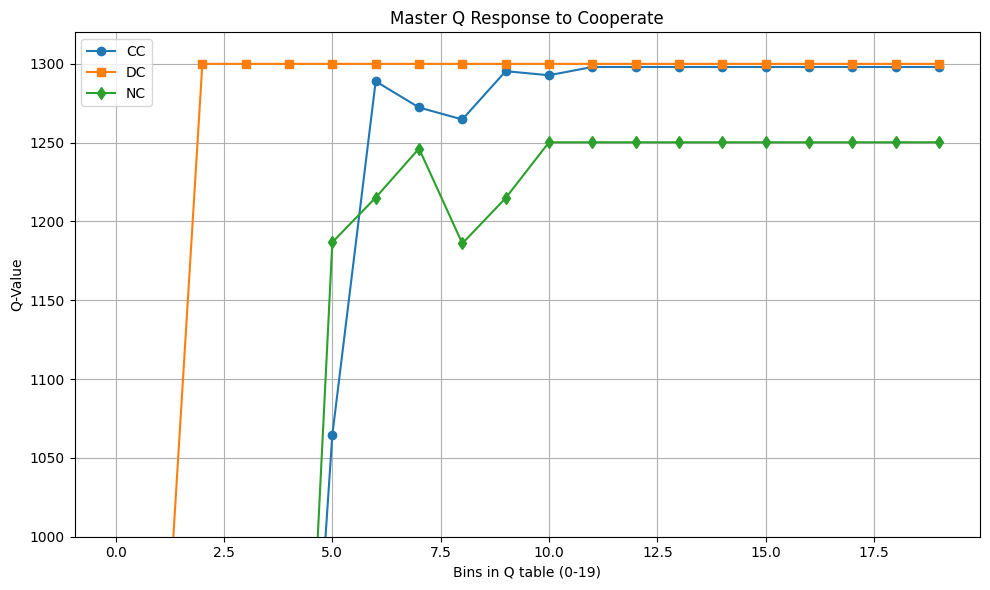

In [153]:

CC_arr = np.transpose(final_Q[:,0,0])
CD_arr = np.transpose(final_Q[:,0,1])
DC_arr = np.transpose(final_Q[:,1,0])
DD_arr = np.transpose(final_Q[:,1,1])
CN_arr = np.transpose(final_Q[:,0,2])
DN_arr = np.transpose(final_Q[:,1,2])
NN_arr = np.transpose(final_Q[:,2,2])
NC_arr = np.transpose(final_Q[:,2,0])
ND_arr = np.transpose(final_Q[:,2,1])

x = np.arange(20)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each array with unique labels and markers
plt.plot(x, CC_arr, label="CC", marker='o')
#plt.plot(x, CD_arr, label="CD", marker='x')
plt.plot(x, DC_arr, label="DC", marker='s')
#plt.plot(x, DD_arr, label="DD", marker='^')
#plt.plot(x, CN_arr, label="CN", marker='v')
#plt.plot(x, DN_arr, label="DN", marker='>')
#plt.plot(x, NN_arr, label="NN", marker='<')
plt.plot(x, NC_arr, label="NC", marker='d')
#plt.plot(x, ND_arr, label="ND", marker='p')

# Add labels, legend, and title
plt.plot(figsize =(5.75, 2.6))
plt.xlabel("Bins in Q table (0-19)")
plt.ylabel("Q-Value")
plt.title("Master Q Response to Cooperate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(1000,1320)

# Show the plot
plt.show()


In [154]:
final_Q.shape

(20, 3, 3)

In [155]:
window = 1000
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)
profitability_arr, profitability_arr2 = moving_avg(samlet_prof, samlet_prof2, window)


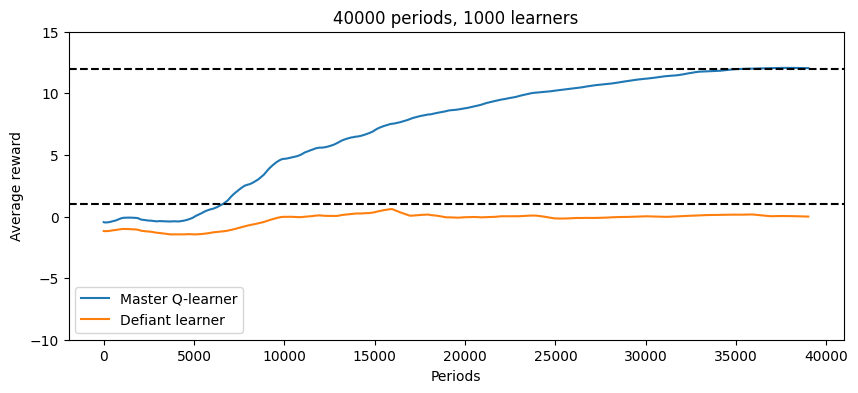

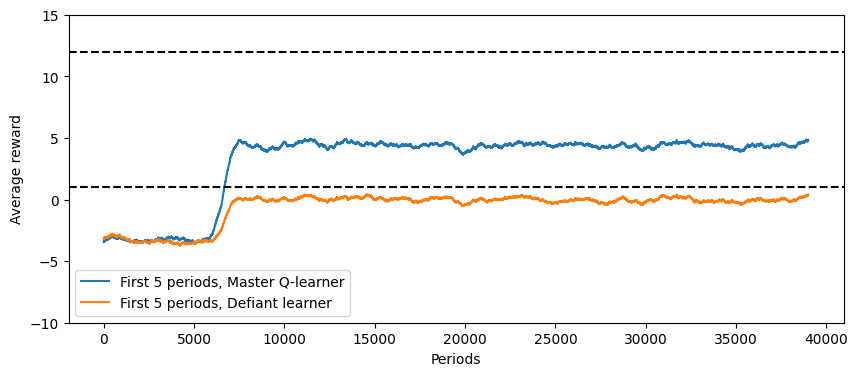

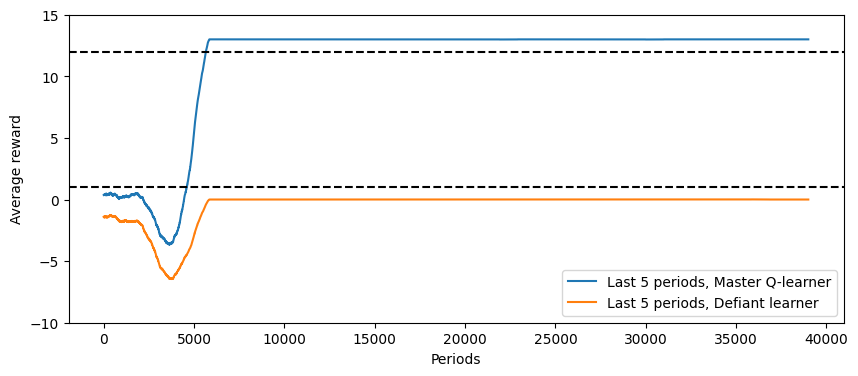

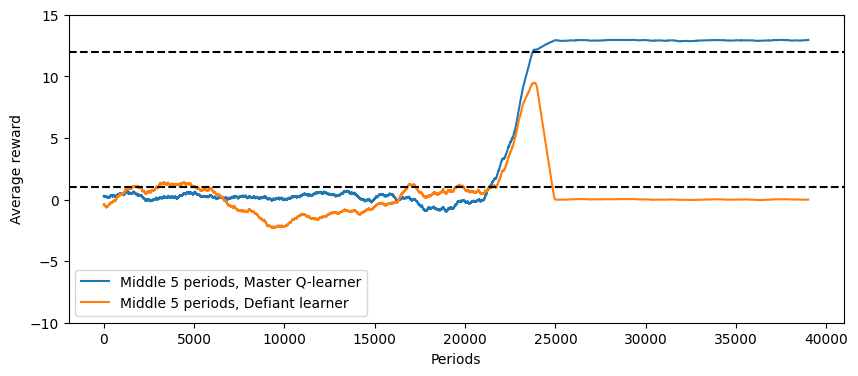

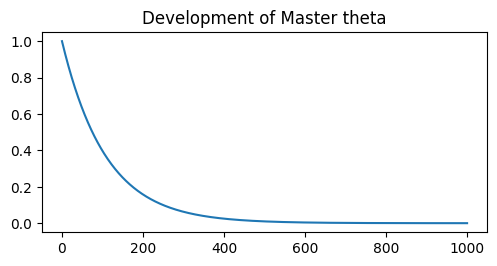

In [169]:
t_arr1 = np.arange(0,local_periods-window-1)
t_arr2 = np.arange(0,local_periods-window-1)
fig, ax = plt.subplots(figsize =(10, 4))
plt.plot(t_arr1,profitability_arr,'-',label=f"{player_1}")
plt.plot(t_arr2,profitability_arr2,'-', label=fr"{player_2}")
plt.title(f"{local_periods} periods, {learners} learners")
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Periods")
plt.ylabel("Average reward")
plt.axhline(y=12, color='k', linestyle = '--')
plt.axhline(y=1, color='k', linestyle = '--')
plt.ylim(-10,15)
plt.legend()
plt.savefig(f'{player_1} vs {player_2}.png', bbox_inches='tight', format='png')
plt.show()

first_fivep1 = rewards_p1[0:5,:]
first_fivep2 = rewards_p2[0:5,:]

last_fivep1 = rewards_p1[-5:,:]
last_fivep2 = rewards_p2[-5:,:]

middle_fivep1 = rewards_p1[int(np.floor(learners/2)):int(np.floor(learners/2)+5),:]
middle_fivep2 = rewards_p2[int(np.floor(learners/2)):int(np.floor(learners/2)+5),:]

first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)
middle_profp1, middle_profp2 = prof_means(middle_fivep1, middle_fivep2)

profitability_first1_5, profitability_first2_5 = moving_avg(first_prof1_5, first_prof2_5, window)
t_arr1 = np.arange(0,local_periods - window-1)
t_arr2 = np.arange(0,local_periods - window-1)
fig, ax = plt.subplots(figsize =(10, 4))
plt.plot(t_arr1,profitability_first1_5,'-',label=f'First 5 periods, {player_1}')
plt.plot(t_arr2,profitability_first2_5,'-', label=f'First 5 periods, {player_2}')
plt.axhline(y=12, color='k', linestyle = '--')
plt.axhline(y=1, color='k', linestyle = '--')
plt.xlabel("Periods")
plt.ylabel("Average reward")
plt.ylim(-10,15)
plt.legend()
plt.savefig(f'First5{player_1} vs {player_2}.png', bbox_inches='tight', format='png')
plt.show()

profitability_last1_5, profitability_last2_5 = moving_avg(last_prof1_5, last_prof2_5, window)
t_arr1 = np.arange(0,local_periods - window-1)
t_arr2 = np.arange(0,local_periods - window-1)
fig, ax = plt.subplots(figsize =(10, 4))
plt.plot(t_arr1,profitability_last1_5,'-',label=f'Last 5 periods, {player_1}')
plt.plot(t_arr2,profitability_last2_5,'-', label=f'Last 5 periods, {player_2}')
plt.axhline(y=12, color='k', linestyle = '--')
plt.axhline(y=1, color='k', linestyle = '--')
plt.xlabel("Periods")
plt.ylabel("Average reward")
plt.ylim(-10,15)
plt.legend()
plt.savefig(f'Last 5{player_1} vs {player_2}.png', bbox_inches='tight', format='png')
plt.show()

profitability_middle1_5, profitability_middle2_5 = moving_avg(middle_profp1, middle_profp2, window)
t_arr1 = np.arange(0,local_periods - window-1)
t_arr2 = np.arange(0,local_periods - window-1)
fig, ax = plt.subplots(figsize =(10, 4))
plt.plot(t_arr1,profitability_middle1_5,'-',label=f'Middle 5 periods, {player_1}')
plt.plot(t_arr2,profitability_middle2_5,'-', label=f'Middle 5 periods, {player_2}')
plt.axhline(y=12, color='k', linestyle = '--')
plt.axhline(y=1, color='k', linestyle = '--')
plt.xlabel("Periods")
plt.ylabel("Average reward")
plt.ylim(-10,15)
plt.legend()
plt.show()

arr = np.zeros(1000)
t = np.arange(0,1000,1)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
for i in range(1000):
    arr[i] = epsilon = (1-0.0092)**i

plt.plot(t,arr,'-',label='generational Q_learner')

plt.title(f"Development of Master theta")
plt.show()


In [157]:
def many_many_games(reps):
    end_prof1 = np.zeros([reps,1000])
    end_prof2 = np.zeros([reps,1000])
    theta= 0.00023023
    alpha = 0.3
    learners = 500
    local_periods = 40000

    window = 250
    delta = 0.99

    #player options:
    for i in range(reps):
        if i % (reps // 10) == 0:
            progress = (i / reps) * 100
            print(f"THE OVERALL Progress: {progress:.0f}% done")
        rewards_p1, rewards_p2, avg_prof, avg_prof2, final_Q, simple_q, choices1, choices2, CC_arr, q_simp2, player_1, player_2 = many_games(options, local_periods, alpha, theta, learners , delta, init_Q)
        samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)
        end_prof1[i] = samlet_prof[-1000:]
        end_prof2[i] = samlet_prof2[-1000:]

    return end_prof1, end_prof2

In [158]:
''' REPETITIONS; WORK IN PROGRESS'''
# def end_prof(p1_prof, p2_prof):
#     end_prof1 = np.mean(np.array(([i[-1000:] for i in p1_prof])), axis=1)
#     end_prof2 = np.mean(np.array(([i[-1000:] for i in p2_prof])), axis=1)
    
#     return end_prof1, end_prof2

# many_profs, many_profs2 = many_many_games(10)

# firm1, firm2 = end_prof(many_profs, many_profs2)


# heatmap, xedges, yedges = np.histogram2d(firm1, firm2, bins=12)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# cb = plt.colorbar()
# cb.set_label('profit')
# plt.show()
# ##ax = sns.heatmap((firm1, firm2), linewidth=0.5)
# #plt.show()
# print('starting mean calculation')
# meantime = time.time()

' REPETITIONS; WORK IN PROGRESS'

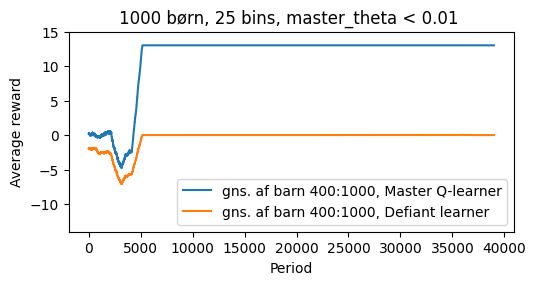

In [159]:

first_fivep1 = rewards_p1[998:999,:]
first_fivep2 = rewards_p2[998:999,:]

last_fivep1 = rewards_p1[-5:,:]
last_fivep2 = rewards_p2[-5:,:]

middle_fivep1 = rewards_p1[int(np.floor(learners/2)):int(np.floor(learners/2)+5),:]
middle_fivep2 = rewards_p2[int(np.floor(learners/2)):int(np.floor(learners/2)+5),:]

first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)
middle_profp1, middle_profp2 = prof_means(middle_fivep1, middle_fivep2)

profitability_first1_5, profitability_first2_5 = moving_avg(first_prof1_5, first_prof2_5, window)

t_arr1 = np.arange(0,local_periods - window-1)
t_arr2 = np.arange(0,local_periods - window-1)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_first1_5,'-',label=f'gns. af barn 400:1000, {player_1}')
plt.plot(t_arr2,profitability_first2_5,'-', label=f'gns. af barn 400:1000, {player_2}')
plt.title("1000 børn, 25 bins, master_theta < 0.01 ")
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Period")
plt.ylabel("Average reward")
plt.ylim(-14,15)
plt.legend()
plt.show()

In [160]:
print(final_Q)

[[[ 406.31919472  399.93376609  942.408906  ]
  [ 914.8543877   917.02277884  315.83882615]
  [ 327.34077447  303.99233151  366.93003568]]

 [[ 572.84557244  653.75372042  863.31975445]
  [ 852.18133783  715.43081007  550.49718216]
  [ 528.7595937   773.7676506   499.57735498]]

 [[ 571.30787593  527.41456582  540.74115187]
  [1299.99674043  568.86708437  541.10960087]
  [ 575.31423322 1022.69102611  828.53569048]]

 [[ 609.36041538  588.87020547  768.47499429]
  [1300.          590.20900872  584.23546305]
  [ 597.48884977  810.95393379  584.98982653]]

 [[ 653.83889853  575.65504588  909.23802726]
  [1300.          635.52605663  620.15773894]
  [ 631.72260118  916.00886299  626.28110958]]

 [[1064.6357445   594.01267904  913.83582468]
  [1300.          587.91738389  479.47199039]
  [1186.83780667  881.50651071  550.2785443 ]]

 [[1288.92598552  569.81489286  705.5751194 ]
  [1300.          607.06076998  618.57750241]
  [1215.12522131  705.7568982   560.10712342]]

 [[1272.32791674  60

In [161]:
np.shape(rewards_p1)

(1000, 39998)

In [162]:
print(choices1[-1501:])
#print(choices2[-2500:])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [163]:
first_fivep1 = rewards_p1[0:5,:]
first_fivep2 = rewards_p2[0:5,:]

last_fivep1 = rewards_p1[-5:,:]
last_fivep2 = rewards_p2[-5:,:]

In [164]:
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

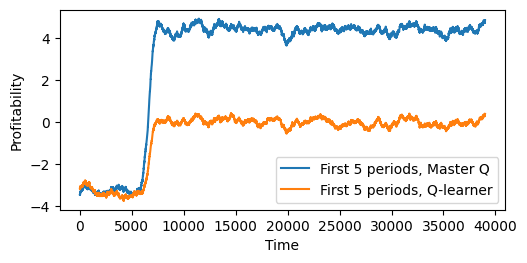

In [165]:
profitability_first1_5, profitability_first2_5 = moving_avg(first_prof1_5, first_prof2_5, window)
t_arr1 = np.arange(0,local_periods - window-1)
t_arr2 = np.arange(0,local_periods - window-1)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_first1_5,'-',label='First 5 periods, Master Q')
plt.plot(t_arr2,profitability_first2_5,'-', label='First 5 periods, Q-learner')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0,5)
plt.legend()
plt.show()

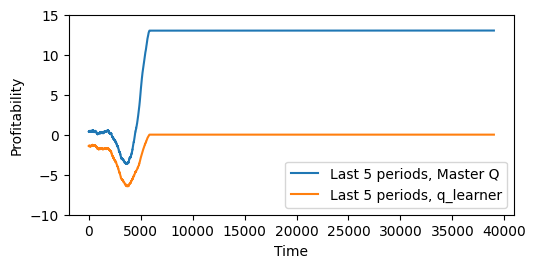

In [166]:
profitability_last1_5, profitability_last2_5 = moving_avg(last_prof1_5, last_prof2_5, window)
t_arr1 = np.arange(0,local_periods - window-1)
t_arr2 = np.arange(0,local_periods - window-1)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_last1_5,'-',label='Last 5 periods, Master Q')
plt.plot(t_arr2,profitability_last2_5,'-', label='Last 5 periods, q_learner')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
plt.ylim(-10,15)
plt.legend()
plt.show()

In [167]:
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

ValueError: x and y must have same first dimension, but have shapes (98999,) and (38999,)

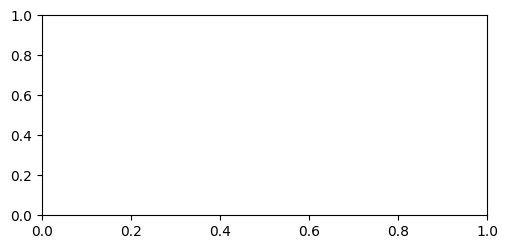

In [168]:
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)

profitability_arr, profitability_arr2 = moving_avg(samlet_prof, samlet_prof2, 1000)
avg_timend = time.time()
#print('ending moving average. time: ', (avg_timend - avgtime))
#np.savetxt("<file>.csv", moving_averages, delimiter = ',')
#print(moving_averages)

t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_arr,'-',label='generational Q_learner')
plt.plot(t_arr2,profitability_arr2,'-', label='Regular old Q player')
plt.axhline(y=3, color='k', linestyle = '--', label='Fully collusive')
plt.axhline(y=1, color='k', linestyle = '--', label='Nash eq.')
plt.xlabel("Time")
plt.ylabel("Avg. reward")
plt.ylim(0,5)
plt.legend()
plt.show()

In [ ]:
arr = np.transpose(CC_arr)
t = np.arange(0,100,1)

arr.shape
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t,arr[0],'-',label='Første C,C')
plt.plot(t,arr[14],'-', label='Anden C,C')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Learners")
plt.ylabel("Q-værdi")
#plt.axhline(y=3, color='k', linestyle = '--')
#plt.axhline(y=, color='k', linestyle = '--')
#plt.ylim(-2,5)
plt.legend()
plt.show()

# EXPERIMENTS WITH LONGER PERIODS #

In [95]:
options = np.array([0,1,2])
init_Q = np.zeros((15,3,3))
#200.000 periods: 
local_periods = 300000
learners = 200
#theta = 0.00004605
rewards_p1, rewards_p2, avg_prof, avg_prof2, final_Q2, bla, choices1, choices2, bla, bla = many_games(options, local_periods, 0.3, 0.00009199, learners ,0.95, final_Q)
final_Q2

run # 1 of  200 runs
run # 2 of  200 runs
run # 3 of  200 runs
run # 4 of  200 runs
run # 5 of  200 runs
run # 6 of  200 runs
run # 7 of  200 runs
run # 8 of  200 runs
run # 9 of  200 runs
run # 10 of  200 runs
run # 11 of  200 runs
run # 12 of  200 runs
run # 13 of  200 runs
run # 14 of  200 runs
run # 15 of  200 runs
run # 16 of  200 runs
run # 17 of  200 runs
run # 18 of  200 runs
run # 19 of  200 runs
run # 20 of  200 runs
run # 21 of  200 runs
run # 22 of  200 runs
run # 23 of  200 runs
run # 24 of  200 runs
run # 25 of  200 runs
run # 26 of  200 runs
run # 27 of  200 runs
run # 28 of  200 runs
run # 29 of  200 runs
run # 30 of  200 runs
run # 31 of  200 runs
run # 32 of  200 runs
run # 33 of  200 runs
run # 34 of  200 runs
run # 35 of  200 runs
run # 36 of  200 runs
run # 37 of  200 runs
run # 38 of  200 runs
run # 39 of  200 runs
run # 40 of  200 runs
run # 41 of  200 runs
run # 42 of  200 runs
run # 43 of  200 runs
run # 44 of  200 runs
run # 45 of  200 runs
run # 46 of  200 ru

array([[[ 7.23197906e+00,  4.91384169e+00, -5.36749982e-01],
        [ 1.20730613e+01,  1.53012318e+00, -7.40176221e+00],
        [ 4.01083024e+00, -8.57775066e-01, -8.93693366e+00]],

       [[ 5.89888394e+01,  2.31658786e+01,  3.38978456e+01],
        [ 2.83421391e+01,  5.39842210e+01,  7.92767845e+00],
        [ 1.81895092e+01,  5.33330996e+00,  3.87831190e+00]],

       [[ 5.99627201e+01,  2.03096814e+01,  3.56233645e+01],
        [ 3.72772318e+01,  5.62634204e+01, -1.05710631e+01],
        [ 1.87392699e+01, -1.05590631e+00, -1.37537721e+01]],

       [[ 6.00000000e+01,  1.38236004e+00,  3.51363377e+01],
        [ 2.55286311e+01,  3.55761122e+01, -1.88060997e+01],
        [ 8.08414287e+00, -1.57067214e+01, -1.54574485e+01]],

       [[ 6.00000000e+01,  2.70782330e+01,  3.00334639e+01],
        [ 2.15255689e+01, -3.18419793e-01, -1.66519285e+01],
        [ 1.20725249e+01, -1.19291354e+01, -1.60495289e+01]],

       [[ 6.00000000e+01,  1.16972062e-04,  2.13804341e+01],
        [ 3.58

In [96]:
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)

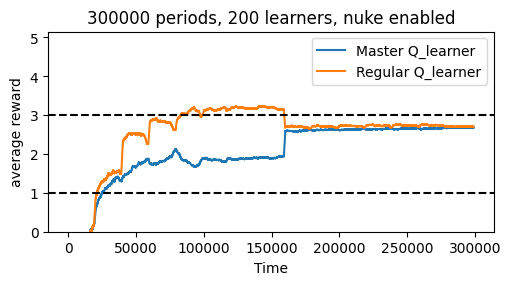

In [98]:

profitability_arr, profitability_arr2 = moving_avg(samlet_prof, samlet_prof2, 1000)
avg_timend = time.time()
#print('ending moving average. time: ', (avg_timend - avgtime))
#np.savetxt("<file>.csv", moving_averages, delimiter = ',')
#print(moving_averages)

t_arr1 = np.arange(0,298999)
t_arr2 = np.arange(0,298999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_arr,'-',label='Master Q_learner')
plt.plot(t_arr2,profitability_arr2,'-', label='Regular Q_learner')
plt.title(f"{local_periods} periods, {learners} learners, nuke enabled")
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("average reward")
plt.axhline(y=3, color='k', linestyle = '--')
plt.axhline(y=1, color='k', linestyle = '--')
plt.ylim(0,5.15)
plt.legend()
plt.show()

In [99]:
first_fivep1 = rewards_p1[0:10,:]
first_fivep2 = rewards_p2[0:10,:]

last_fivep1 = rewards_p1[-20:,:]
last_fivep2 = rewards_p2[-20:,:]

In [100]:
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

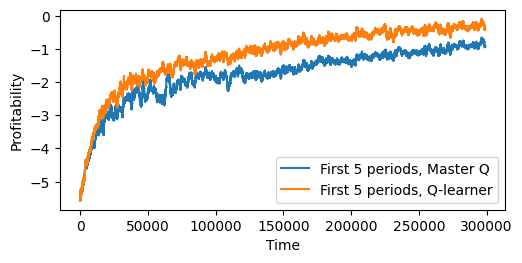

In [102]:
profitability_first1_5, profitability_first2_5 = moving_avg(first_prof1_5, first_prof2_5, 1000)
t_arr1 = np.arange(0,298999)
t_arr2 = np.arange(0,298999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_first1_5,'-',label='First 5 periods, Master Q')
plt.plot(t_arr2,profitability_first2_5,'-', label='First 5 periods, Q-learner')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0,5)
plt.legend()
plt.show()

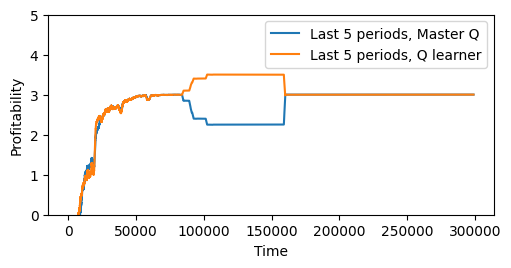

In [103]:
profitability_last1_5, profitability_last2_5 = moving_avg(last_prof1_5, last_prof2_5, 1000)
t_arr1 = np.arange(0,298999)
t_arr2 = np.arange(0,298999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_last1_5,'-',label='Last 5 periods, Master Q')
plt.plot(t_arr2,profitability_last2_5,'-', label='Last 5 periods, Q learner')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
plt.ylim(0.00,5)
plt.legend()
plt.show()

# EXPERIMENTS WITH THETA EXPLORATION #

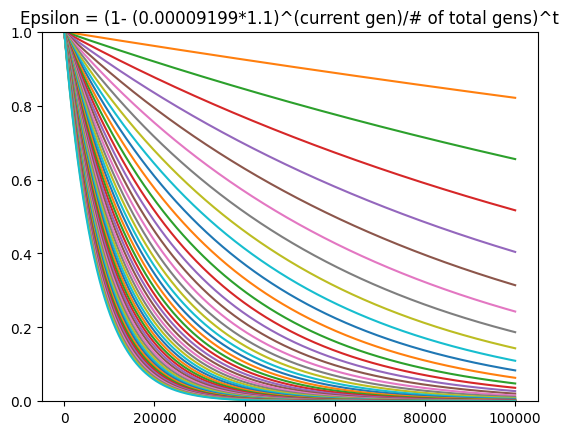

In [31]:
arr = np.zeros(100000)
t = np.arange(0,100000,1)
# def master_epsilon(theta,i,lean):
#     theta*(i**2/)
for j in range(0,100,2):
    for i in range(100000):
        arr[i] = (1-(0.00009199*(j**1.1)/100))**i
    plt.plot(t,arr,'-',label=f"gen{j}")
plt.title("Epsilon = (1- (0.00009199*1.1)^(current gen)/# of total gens)^t")
#plt.legend()
plt.ylim(0,1)
plt.show()

# arr = np.zeros(1000)
# t = np.arange(0,1000,1)
# # def master_epsilon(theta,i,lean):
# #     theta*(i**2/)
# for j in range(0,1000,2):
#     for i in range(1000):
#         arr[i] = (1-(0.0092*(j**1.25)/1000))**i

#     plt.plot(t,arr,'-',label='generational Q_learner')

# plt.ylim(0,1)
# plt.show()

# arr = np.zeros(2000000)
# t = np.arange(0,1000,1)
# # def master_epsilon(theta,i,lean):
# #     theta*(i**2/)
# for j in range(0,1000,2):
#     for i in range(1000):
#         arr[i] = (1-(0.0092*(j**1.25)/1000))**i

#     plt.plot(t,arr,'-',label='generational Q_learner')

# plt.ylim(0,1)
# plt.show()

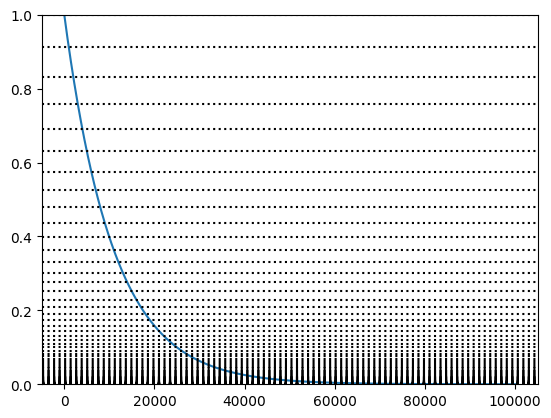

In [32]:
arr = np.zeros(100000)
t = np.arange(0,100000,1)
for i in range(100000):
    arr[i] = epsilon = (1-0.0000922)**i

arr2 = np.zeros(100)
t2 = np.arange(0,100,1)
for i in range(100):
    arr2[i] = epsilon = (1-0.087988)**i



plt.plot(t,arr,'-',label='generational Q_learner')
for i in arr2:
    plt.axhline(y=i, color='k', linestyle = 'dotted')
plt.ylim(0,1)
plt.show()


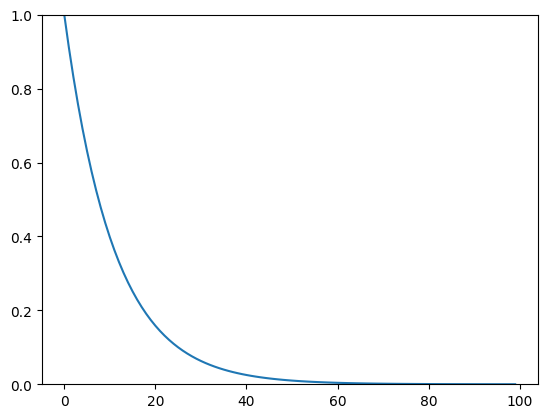

In [105]:
arr = np.zeros(100)
t = np.arange(0,100,1)
for i in range(100):
    arr[i] = epsilon = (1-0.087988)**i
plt.plot(t,arr,'-',label='generational Q_learner')
plt.ylim(0,1)
plt.show()